<a href="https://colab.research.google.com/github/mbalbi/ciencia_de_datos/blob/main/tps/1c2024/Practica_8_completa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clase 8: Inferencia estadística

En este clase vamos a utilizar librerías para resolver numéricamente (utilizando cadenas de Markov) problemas de inferencia estadística. Esto nos permitirá resolver problemas más complejos, y dar mayor libertad a la hora de modelar la generación de datos y de elegir distribuciones a priori de los parámetros.

En particular usaremos dos librerías:
- Bambi (BAyesian Model-Building Interface): para la construcción y calibración de modelos
- ArviZ: para la visualización de los resultados de la inferencia y la evaluación de los modelos

## Ejemplo: Sismos en San Juan (soluciones por MCMC)

En este ejemplo vamos a seguir el ajuste de un modelo para predecir el número de sismos en la Provincia de San Juan por año.

La pregunta que queremos contestar es:

- ¿Cuál es la probabilidad de que no haya sismos de magnitud moderada en los próximos 5 años?

Para ello, descargamos de la página de [USGS](https://earthquake.usgs.gov/earthquakes/search/), los datos de los últimos 80 años. La limpieza de datos la vimos en el Colab anterior, así que directamente cargamos los datos limpios.

### Datos

Como ya hicimos todo el filtrado la clase pasada, esta vez vamos a trabajar directamente sobre el dataset limpio/filtrado. Teníamos 63 sismos entre 1974 y 2021 con epicentro en San Juan.

Empecemos importando las librerías clave y cargando el archivo.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io

try:
  import bambi as bmb
except:
  !pip install bambi
  import bambi as bmb

import arviz as az

from google.colab import files

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.9/107.9 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 1.6 MB/s eta 0:00:00


In [3]:
#Abrimos un archivo local, es decir, que ha sido descargado en su computadora
uploaded = files.upload()

Saving sismos_SanJuan_filt.csv to sismos_SanJuan_filt.csv


In [4]:
#Se crea un DataFrame
df_sismos = pd.read_csv(io.BytesIO(uploaded['sismos_SanJuan_filt.csv']))
df_sismos.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2021-11-03 03:17:48.635000+00:00,-32.6971,-70.0638,100.25,5.7,mww,NaN,18.0,0.415,0.77,...,2022-01-14T17:58:56.040Z,Chile-Argentina border region,earthquake,4.6,1.3,0.041,58.0,reviewed,us,us
1,2021-03-08 12:48:07.330000+00:00,-32.2039,-69.9055,106.66,5.2,mww,NaN,40.0,0.780,0.96,...,2021-05-21T19:48:28.040Z,"95 km NE of Los Andes, Chile",earthquake,4.3,3.7,0.060,27.0,reviewed,us,us
2,2021-01-19 02:46:22.380000+00:00,-31.8334,-68.7992,20.81,6.4,mww,NaN,22.0,0.303,0.95,...,2022-07-05T00:04:17.684Z,"26 km SW of Pocito, Argentina",earthquake,2.9,3.6,0.055,32.0,reviewed,us,us
3,2019-05-20 11:18:33.131000+00:00,-31.4782,-70.0028,108.00,5.5,mww,NaN,28.0,0.867,1.10,...,2021-02-08T02:59:04.650Z,"57 km WSW of Calingasta, Argentina",earthquake,5.8,1.8,0.068,21.0,reviewed,us,us
4,2018-12-31 10:49:41.250000+00:00,-31.7756,-69.2343,99.39,5.3,mww,NaN,30.0,0.522,1.17,...,2021-02-08T03:06:09.004Z,"52 km SSE of Calingasta, Argentina",earthquake,6.4,3.8,0.050,39.0,reviewed,us,us


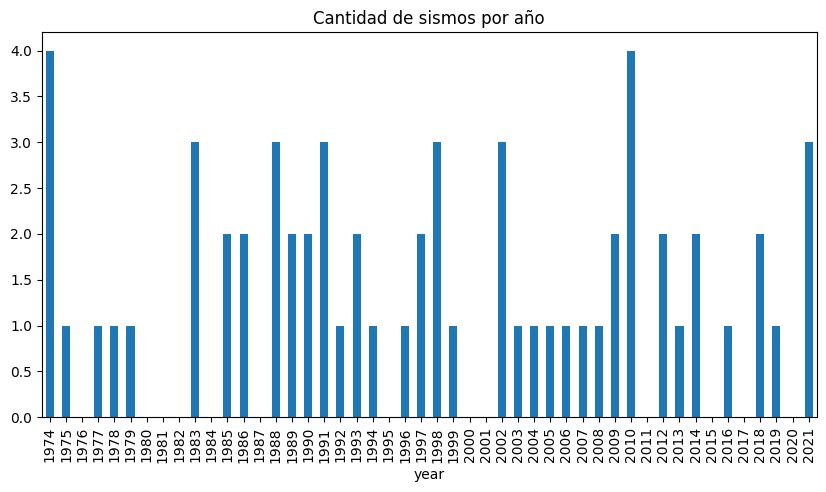

In [5]:
# Convertir a datetime
df_sismos['time'] = pd.to_datetime(df_sismos['time'],format='ISO8601')

# Conteo por año
Data = df_sismos.groupby(pd.Grouper(key='time', freq='YE')).count().reset_index()
Data['year'] = Data['time'].dt.year

# Grafico
Data.plot(x='year', y='mag',kind='bar', legend=False, figsize=(10,5))
plt.title('Cantidad de sismos por año')
plt.show()

In [6]:
# Chequear media y varianza
mu1 = Data['mag'].mean()
s1 = Data['mag'].var()
print('media',mu1)
print('varianza',s1)

media 1.3125
varianza 1.2832446808510638


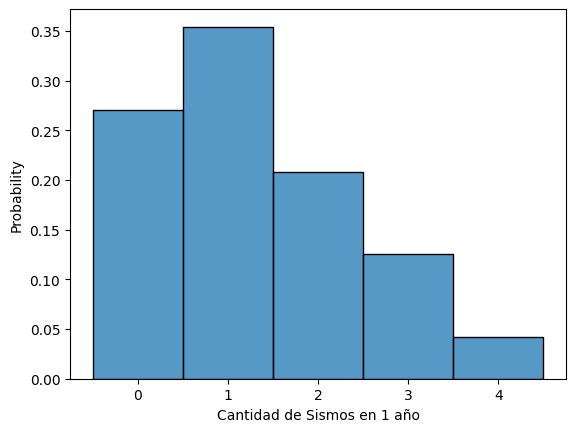

In [7]:
sns.histplot(Data['mag'],label='Sismos por año',stat='probability',discrete=True)
#plt.legend()
plt.xlabel('Cantidad de Sismos en 1 año')
plt.show()

Hasta acá, nada nuevo. ¡Son los mismos datos de antes! Podríamos resolver en forma analítica si adoptamos como priori una distribución Gamma (distribución conjugada).

### Construcción del modelo en Bambi

En cambio, vamos a resolver por Cadenas de Markov, ya que nos va a dar más flexibilidad para plantear problemas más complejos y más libertad para elegir distribuciones a priori.

#### Ejemplo: El default para una Poisson

La construcción de un modelo de Bambi se hace con la función `Model`. Hay 3 cosas a definir:
- La Fórmula: Es la ecuación que describe al parámetro "valor medio" (o una transformación de este) de la distribución elegida
- La Familia: Qué función de distribución define la verosimilitud
- El Link: Qué transformación aplica a la fórmula (¿es para el el valor medio? ¿El logaritmo? ¿su inversa?)
- Las distribuciones a priori: `Bambi` tiene opciones poco informativas si todo está por default. La recomendación es adoptarlas ustedes.

La familia por default en `Bambi` es el modelo Normal, pero tiene varios modelos ya pre-cargados (por ejemplo, el modelo de Poisson). Cada familia tiene, a su vez, un Link por default. En el caso de Poisson es `log`. Es decir, que estoy ajustando al logaritmo del valor medio:

Modelo:

$$y \sim Poisson(\lambda)$$

Fórmula para el valor medio:

$$ln(\lambda) = Intercept$$

Distribución a priori del parámetro

$$p(Intercept)\sim N(\mu,\sigma)$$

A continuación, les dejamos un ejemplo de la carga de datos. Vean que los datos provienen de un dataframe, y la formula describe a la columna `mag` del dataframe, que es mi variable `y`.

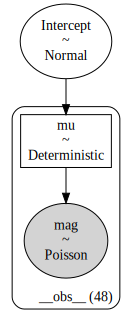

In [8]:
# Construccion del Modelo de Poisson
model_1 = bmb.Model('mag~1',data=Data,family='poisson')

model_1.build()
model_1.graph()

Con el método `plot_priors` podemos ver la distribución a priori adoptada. Si queremos ver el intervalo de confianza, con `hdi_prob` podemos setearlo. Podrán ver que la priori de `Bambi` suele ser muy poco informativa.

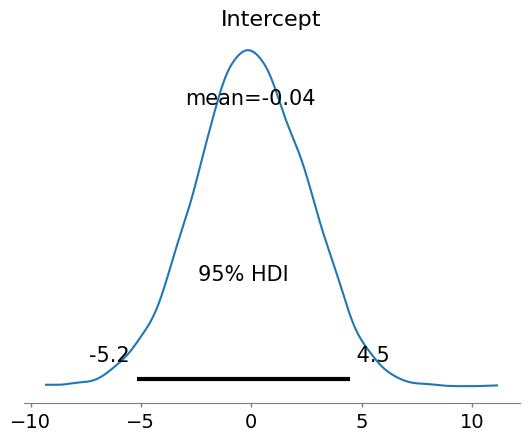

In [9]:
model_1.plot_priors(hdi_prob=0.95)
plt.show()

#### Ejemplo: Detallando las distribuciones a priori y el parámetro a ajustar

Ahora vamos a hacer lo mismo pero definiendo nosotros el link y adoptando nuestra propia distribución a priori para el `Intercept` ($\lambda$). Sabemos que $\lambda$ es positivo. Si, por ejemplo, pensamos que debe estar entre 0.5 y 4.5, y queremos usar una distribución LogNormal sabemos que:

Valor Medio: $\mu = 2.5$

Desvío: $\sigma = 1$

Por lo tanto, el coeficiente de variación es $s = \mu/\sigma = 0.4$.

Finalmente, entonces el parámetro $m$ (el logaritmo de la mediana) es: $m = ln(\mu) - s^{2}/2 = 0.84$

El modelo que queremos construir entonces es:

Modelo:

$$y \sim Poisson(\lambda)$$

Fórmula para el valor medio:

$$\lambda = Intercept$$

Distribución a priori del parámetro

$$p(Intercept)\sim LN(m,s)$$

Abajo les dejamos cómo se hace en `Bambi`. Noten que las prioris se cargan como un diccionario, y la importancia de aclarar el `link`.

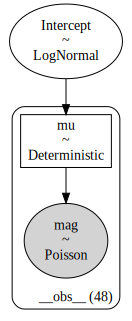

In [10]:
# Valor Medio
med = 2.5

# Desvio para conseguir intervalo de confianza
des = (4.5-0.5)/4

# Parametro s (coeficiente de variacion)
s = des/med

# Parametro m (logaritmo de la mediana)
m = np.log(med)-0.5*s**2

# Construccion del Modelo de Poisson
# Prioris
prioris = {"Intercept": bmb.Prior("Lognormal",mu=m,sigma=s)}

# Modelo
model_2 = bmb.Model('mag~1',data=Data,family='poisson',link='identity',
                    priors=prioris)

model_2.build()
model_2.graph()

¡Siempre es importante graficar las prioris para verificar que la distribución a priori resultó la que ustedes querían! Es nuy común que `Bambi` no la tome, por ejemplo, por nombrar mal el parámetro en el diccionario. O que los valores en la priori no sean los que uno realmente quería introducir al problema.

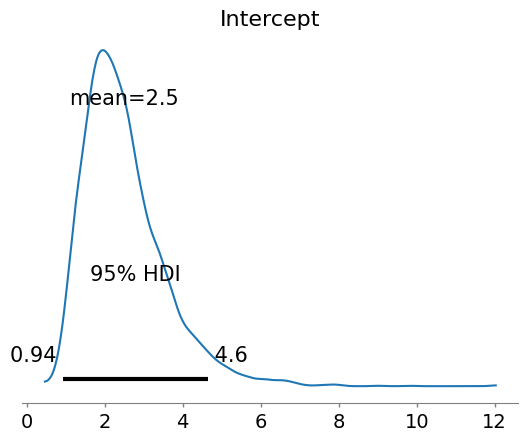

In [11]:
model_2.plot_priors(hdi_prob=0.95)
plt.show()

#### Ejemplo: Si quisiera hacer inferencia sobre el logaritmo del parámetro

A continuación se deja el mismo ejemplo/caso de arriba. Pero explicitamente modelando al logaritmo de $\lambda$. Recordando que si una V.A es lognormal, su logaritmo es Normal, el modelo sería:

Modelo:

$$y \sim Poisson(\lambda)$$

Fórmula para el valor medio:

$$ln(\lambda) = Intercept$$

Distribución a priori del parámetro

$$p(Intercept)\sim N(m,s)$$

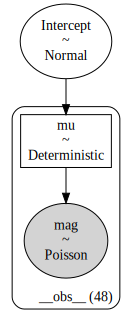

In [12]:
# Valor Medio
med = 2.5

# Desvio para conseguir intervalo de confianza
des = (4.5-0.5)/4

# Parametro s (coeficiente de variacion)
s = des/med

# Parametro m (logaritmo de la mediana)
m = np.log(med)-0.5*s**2

# Construccion del Modelo de Poisson
# Prioris
prioris = {"Intercept": bmb.Prior("Normal",mu=m,sigma=s)}

# Modelo
model_2B = bmb.Model('mag~1',data=Data,family='poisson',link='log',
                    priors=prioris)

model_2B.build()
model_2B.graph()

Comparando contra el primer ejemplo, pueden ver que la priori default de `Bambi` es mucho menos informativa que la que indicamos nosotros en el ejercicio.

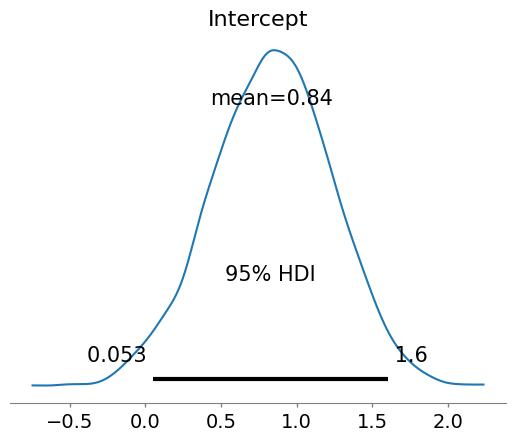

In [13]:
model_2B.plot_priors(hdi_prob=0.95)
plt.show()

#### Ejemplo: Construyendo "de 0" la familia/modelo de generación de datos

Existen situaciones donde la función de verosimilitud no está pre-cargada en `Bambi` (por ejemplo, la LogNormal o el modelo de Gumbel). En esos casos es posible construir manualmente una Familia.

Para construir una Familia, deben indicar cuál es la función de Verosimilitud (del listado de funciones disponibles en `PyMC`), y cuál es el parámetro principal (para el cual se escribe la fórmula, suele ser el valor medio de la distribución). Deben indicar también los `links` por default o posibles para el parámetro.

Como la familia es construida, va a ser necesario obligatoriamente definir nosotros las distribuciones a priori. Abajo les dejamos un ejemplo construyendo la familia Poisson de 0 nosotros, que les puede servir en el Trabajo Final. Como comentario, notaran que estamos usando como priori la distribución Gamma (la distribución conjugada del anterior Colab)

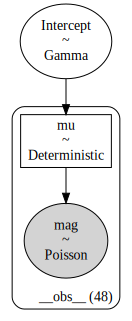

In [14]:
# Definir la función de verosimilitud, indicando el parámetro principal
likelihood = bmb.Likelihood("Poisson", params=["mu"], parent="mu")

# Definir los links de los parámetros
link = {"mu": "identity"}

# Construir la familia a mano
family = bmb.Family("poisson_ICDIC", likelihood, link)

# Definir las prioris
priors = {"Intercept": bmb.Prior("Gamma",alpha=6.25,beta=2.5)}

model_3 = bmb.Model("mag~1", Data, family=family,priors=priors)

# Ver el modelo
model_3.build()
model_3.graph()

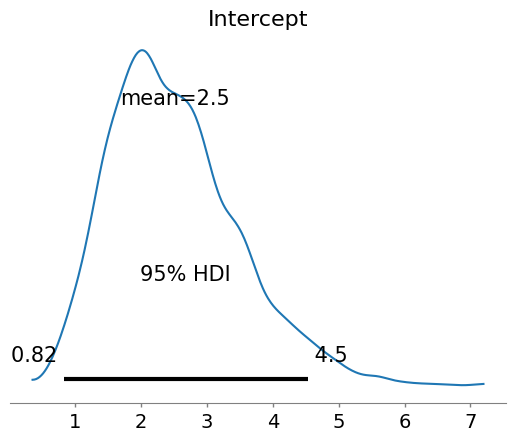

In [15]:
model_3.plot_priors(hdi_prob=0.95)
plt.show()

### Evaluación de las distribuciones a priori

Como vimos antes, siempre es importante revisar qué impacto tienen nuestras distribuciones a priori en el modelo. Para eso podemos ver qué simula antes de ver los datos, y si resulta razonable.

El método de bambi `prior_predictive()` permite hacer nuevas simulaciones/predicciones de la variable utilizando sólo las distribuciones a priori, guardándolas en un Inference Data. Luego, con la función `plot_ppc` pueden graficarlas. Es importante aclarar `group='prior'` en este caso.

Noten que la forma de hacer las simulaciones es nuevamente como réplicas del ensayo, luego presentando la priori predictiva (el promedio de todas esos grupos de simulaciones).

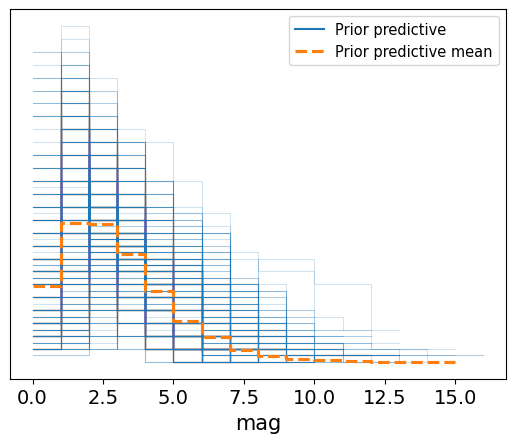

In [16]:
# Simulaciones de la priori predictive
priorcheck_2 = model_2.prior_predictive()

# Gráfico
az.plot_ppc(priorcheck_2,group='prior')
plt.show()

### Realizar la inferencia y evaluar convergencia

El siguiente paso, si vemos bien las prioris que elegimos, es proceder con la inferencia para obtener las distribuciones posteriores. Para ello usamos el método `fit()`. Los variables clave que permite el método son:

- Draws: La cantidad de simulaciones por cadena
- Chains: La cantidad de cadenas (generalmente se hace una por núcleo disponible ya que permite simular en paralelo y ahorrar tiempo. Lo recomendable es hacer al menos 4 cadenas).
- Random_seed: Valor que me permite generar consistencia/manipular la aleatoriedad de las simulaciones.

Esto devuelve un Inference Data (veremos más adelante qué tiene dentro). Lo importante es revisar que la inferencia haya salido bien. Para ello hay que mirar.

- Que no haya divergencias (especialmente en modelos sencillas. Puede aceptarse algunas pocas en modelos complejos con muchos parámetros)
- Que las cadenas sean un ruido blanco sin tendencias o autocorrelación (que sean independientes)
- Que las cadenas hayan convergido y tenga similar variabilidad.

Esto puede hacerse en forma visual mediante la función `plot_trace`. La variable `compact=False` lo que hace es separar en ciertos casos los distintos parámetros simulados para mayor claridad en vez de agruparlos en un mismo gráfico. Debieran ver que las distribuciones posteriores de cada cadena se parezcan entre sí, y que las simulaciones parezcan un ruido blanco superpuesto horizontal.

Luego, el otro dato clave es el Coeficiente $R$, que compara la variable dentro de una misma cadena con la variabilidad entre cadenas. Este número debiera ser **muy** cercano a 1 (entre 0.97 y 1.03 como mucho). ArviZ lo calcula por ustedes con la función `summary`.

Output()

Output()

Output()

Output()

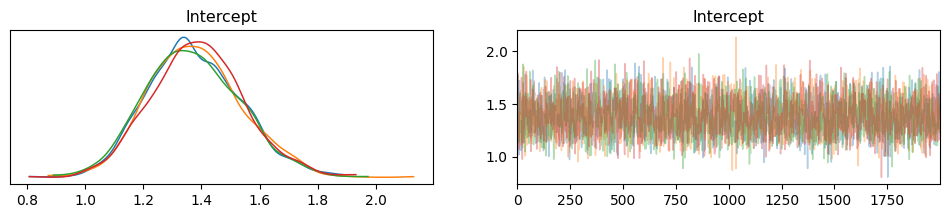

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.379,0.159,1.097,1.719,0.003,0.002,3279.0,5363.0,1.0


In [17]:
# Hacer inferencia
results_2 = model_2.fit(draws=2000,chains=4)

# Diagnóstico de las cadenas

# Grafico
az.plot_trace(results_2, compact=False)
plt.show()

# Numerico
az.summary(results_2,hdi_prob=0.95)

Como dijimos antes, la inferencia devuelve un Inference Data. Abajo pueden ver lo que tiene (¡es clickeable!)

- En `posterior` van a encontrar las simulaciones de la distribución posterior de los parámetros. Es una matriz de (#cadenas,#simulaciones). Después vemos como extraerla como un Numpy Array
- En `observed_data` van a encontrar los datos utilizados para la inferencia/predicción. Es una matriz de (#obs), también extraible como Numpy Array.

In [18]:
results_2

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

### Distribución posterior

Si todo esta bien, ya podemos empezar a informar resultados de nuestra inferencia. La función `plot_posterior` (muy útil y versátil) permite graficar, entre otras cosas la distribución posterior de los parámetros si le entregamos nuestro Inference Data. con `var_names` pueden definir como lista los parámetros que quieren graficar, y con `hdi_prob` el intervalo de confianza. La función devuelve un gráfico que incluye también aspectos claves de la distribución.

Esa misma información la pueden encontrar en forma de tabla con la función `summary` que vimos antes, que acepta las mismas variables para seleccionar parámetros e intervalos de confianza

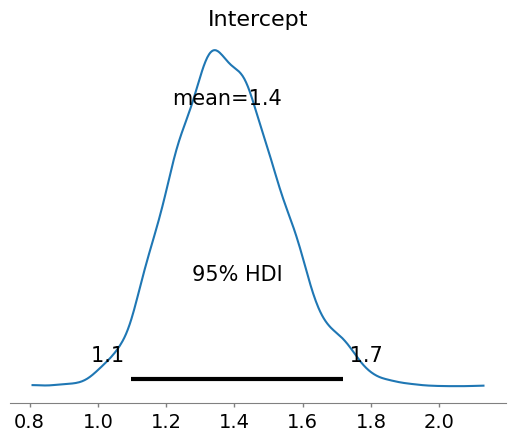

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.379,0.159,1.097,1.719,0.003,0.002,3279.0,5363.0,1.0


In [19]:
# Graficar las distribuciones posteriores
az.plot_posterior(results_2,var_names=['Intercept'],hdi_prob=0.95)
plt.show()

# Resumen de resultados
az.summary(results_2,var_names=['Intercept'],hdi_prob=0.95)

Como nota, es posible extraer los límites del intervalo de confianza con la función `hdi` de ArviZ. Notarán que lo hice extrayendo los datos del Inference Data como matriz (ahora lo vemos bien como se hace). ¡Esto significa que la función sirve para cualquier vector de datos simulados!

In [20]:
IC05,IC95 = az.hdi(np.ravel(results_2.posterior['Intercept'].values), hdi_prob=0.90)
print('Intervalo de confianza del 5%:',IC05)
print('Intervalo de confianza del 95%:',IC95)

Intervalo de confianza del 5%: 1.1072260906450053
Intervalo de confianza del 95%: 1.6222075412621115


### Distribución posterior predictiva (nuevas simulaciones)

So quiero obtener nuevas simulaciones de cosas que no observé (años futuros en este caso), puedo hacerlo con el método `predict`. `kind='response'` indica que quiero simular no solo los parámetros del modelo sino también nuevos datos. Con `inplace=True` indico que quiero sobreescribir el Inference Data agregando las nuevas simulaciones, sin tener que guardarlo en una nueva variable.

Luego, la función `plot_ppc` que vimos antes permite gráficar las réplicas de mi ensayo, la posterior predictiva y comparar contra el histograma de los datos. Ya pueden empezar a ver qué tan probable es que su modelo genere algo parecido a sus datos.

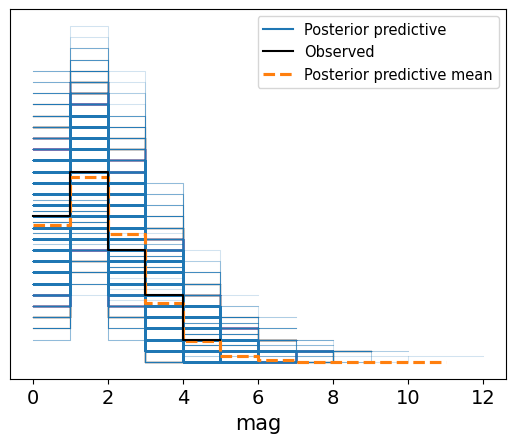

In [21]:
# Nuevas simulaciones (lo guarda en la misma variable de antes con inplace=True)
model_2.predict(results_2, kind="response",inplace=True)

# Grafico
az.plot_ppc(results_2)
plt.show()

### Accediendo a las simulaciones

Como dijimos antes, el resultado de la inferencia y la predicción es un Inference Data. Verán que luego de predecir se agregó una nueva sección de nombre `posterior_predictive`. Allí van a encontrar las simulaciones de los datos/mi variable de interés, en tamaño (#cadenas,#simulaciones,#obs). Es decir, genera muchas réplicas de mi ensayo con el tamaño original de mis datos.

In [22]:
results_2

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Estsa simulaciones pueden extraerse como Numpy Arrays para su manipulación o calculos (valores medios, cuantiles, cálculos de probabilidad, etc.

Abajo les dejamos como hacerlo para la posterior...

In [23]:
results_2.posterior['Intercept'].values

array([[1.47938118, 1.44135493, 1.60029465, ..., 1.73409871, 1.41535111,
        1.36433258],
       [1.35623878, 1.34002922, 1.18152048, ..., 1.49071045, 1.49071045,
        1.26244753],
       [1.33347588, 1.66946827, 1.76987044, ..., 1.50343044, 1.5522856 ,
        1.5522856 ],
       [1.34510754, 1.37816033, 1.37816033, ..., 1.58767273, 1.57870967,
        1.40621999]])

Para la posterior predictiva...

In [24]:
results_2.posterior_predictive['mag'].values

array([[[1, 3, 0, ..., 1, 2, 4],
        [0, 2, 2, ..., 1, 1, 4],
        [1, 2, 2, ..., 1, 1, 6],
        ...,
        [3, 1, 0, ..., 3, 1, 4],
        [2, 0, 1, ..., 1, 1, 0],
        [2, 1, 0, ..., 1, 1, 4]],

       [[0, 1, 1, ..., 3, 3, 0],
        [0, 1, 1, ..., 1, 1, 2],
        [0, 2, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 3, ..., 5, 1, 1],
        [1, 4, 2, ..., 0, 2, 0],
        [0, 2, 0, ..., 0, 1, 1]],

       [[1, 0, 4, ..., 0, 1, 0],
        [0, 2, 3, ..., 2, 3, 0],
        [3, 1, 2, ..., 3, 3, 3],
        ...,
        [0, 1, 3, ..., 0, 1, 1],
        [0, 0, 2, ..., 1, 1, 4],
        [1, 1, 5, ..., 1, 0, 1]],

       [[3, 0, 1, ..., 3, 2, 4],
        [3, 2, 2, ..., 2, 1, 1],
        [5, 1, 0, ..., 1, 2, 1],
        ...,
        [3, 1, 0, ..., 1, 0, 3],
        [1, 2, 3, ..., 5, 1, 2],
        [4, 1, 1, ..., 0, 1, 1]]])

Y para los datos observados que se usaron.

In [25]:
results_2.observed_data['mag'].values

array([4, 1, 0, 1, 1, 1, 0, 0, 0, 3, 0, 2, 2, 0, 3, 2, 2, 3, 1, 2, 1, 0,
       1, 2, 3, 1, 0, 0, 3, 1, 1, 1, 1, 1, 1, 2, 4, 0, 2, 1, 2, 0, 1, 0,
       2, 1, 0, 3])

### Uso del modelo (contestar preguntas)

Todo esto lo hicimos con una razón: contestar nuestra pregunta original.

- ¿Cuál es la probabilidad de que no haya un sismo de moderada magnitud en los próximos 5 años?

Extrayendo los datos como vimos antes, ¡ahora simplemente es un problema de conteo como en el colab anterior de soluciones analíticas!

In [26]:
# Accedo a los datos
Simul = results_2.posterior_predictive['mag'].values

# Probabilidad de 0 sismos en 1 año
P0 = np.mean(np.ravel(Simul)==0)
print('Probabilidad de 0 sismos en 1 año:',round(P0,3))

# Probabilidad de 0 sismos en 5 años
P5 = P0**5
print('Probabilidad de 0 sismo en 5 año:',round(P5,5))

Probabilidad de 0 sismos en 1 año: 0.255
Probabilidad de 0 sismo en 5 año: 0.00108


## Ejemplo: Tiempo entre sismos en San Juan

Retomemos el dataset pero plantiémoslo "al revés" por así decir. En vez de ajustar la cantidad de sismos en un intervalo de tiempo, hagamos un modelo para el intervalo de tiempo entre sismos.

### Datos

Los datos son los mismo de antes, solo que los vamos agrupar de otra manera.

In [27]:
df_sismos.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2021-11-03 03:17:48.635000+00:00,-32.6971,-70.0638,100.25,5.7,mww,NaN,18.0,0.415,0.77,...,2022-01-14T17:58:56.040Z,Chile-Argentina border region,earthquake,4.6,1.3,0.041,58.0,reviewed,us,us
1,2021-03-08 12:48:07.330000+00:00,-32.2039,-69.9055,106.66,5.2,mww,NaN,40.0,0.780,0.96,...,2021-05-21T19:48:28.040Z,"95 km NE of Los Andes, Chile",earthquake,4.3,3.7,0.060,27.0,reviewed,us,us
2,2021-01-19 02:46:22.380000+00:00,-31.8334,-68.7992,20.81,6.4,mww,NaN,22.0,0.303,0.95,...,2022-07-05T00:04:17.684Z,"26 km SW of Pocito, Argentina",earthquake,2.9,3.6,0.055,32.0,reviewed,us,us
3,2019-05-20 11:18:33.131000+00:00,-31.4782,-70.0028,108.00,5.5,mww,NaN,28.0,0.867,1.10,...,2021-02-08T02:59:04.650Z,"57 km WSW of Calingasta, Argentina",earthquake,5.8,1.8,0.068,21.0,reviewed,us,us
4,2018-12-31 10:49:41.250000+00:00,-31.7756,-69.2343,99.39,5.3,mww,NaN,30.0,0.522,1.17,...,2021-02-08T03:06:09.004Z,"52 km SSE of Calingasta, Argentina",earthquake,6.4,3.8,0.050,39.0,reviewed,us,us


Primero, vamos a ordenar los datos en orden cronológico. Luego, vamos a generar una columna que indique el tiempo transcurrido entre sismos en días (con decimales, no en forma discreta).

Así, entonces, nos quedan 63 sismos y 62 intervalos de tiempo entre sismos en un nuevo dataframe.

In [28]:
# Ordeno el Dataframe por Fecha
df_sorted = df_sismos.sort_values(by=['time'])

# Calculo la diferencia entre sismos en días
df_sorted['time_diff'] = df_sorted['time'].diff()
df_sorted['time_diff'] = df_sorted['time_diff'].dt.total_seconds()/60/60/24
df_sorted.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,time_diff
62,1974-01-11 05:18:02.400000+00:00,-31.758,-68.376,122.0,5.4,mb,NaN,NaN,NaN,NaN,...,"9 km S of Nueve de Julio, Argentina",earthquake,NaN,NaN,NaN,NaN,reviewed,us,us,NaN
61,1974-01-23 21:43:51.300000+00:00,-32.165,-69.771,115.0,5.2,mb,NaN,NaN,NaN,NaN,...,"97 km SSW of Calingasta, Argentina",earthquake,NaN,NaN,NaN,NaN,reviewed,us,us,12.684594
60,1974-08-14 17:56:47+00:00,-32.743,-69.015,132.0,5.6,mb,NaN,NaN,NaN,NaN,...,"24 km NW of Mendoza, Argentina",earthquake,NaN,NaN,NaN,NaN,reviewed,us,us,202.842311
59,1974-08-24 18:58:22.700000+00:00,-31.381,-67.378,32.0,5.4,mb,NaN,NaN,NaN,NaN,...,"83 km S of San Agustín de Valle Fértil, Argentina",earthquake,NaN,NaN,NaN,NaN,reviewed,us,us,10.042774
58,1975-11-17 06:45:47.200000+00:00,-31.548,-69.179,122.0,5.3,mb,NaN,NaN,NaN,NaN,...,"33 km SE of Calingasta, Argentina",earthquake,NaN,NaN,NaN,NaN,reviewed,us,us,449.491256


Abajo pueden ver el histograma de los intervalos de tiempo. Parece una exponencial, ¿no?

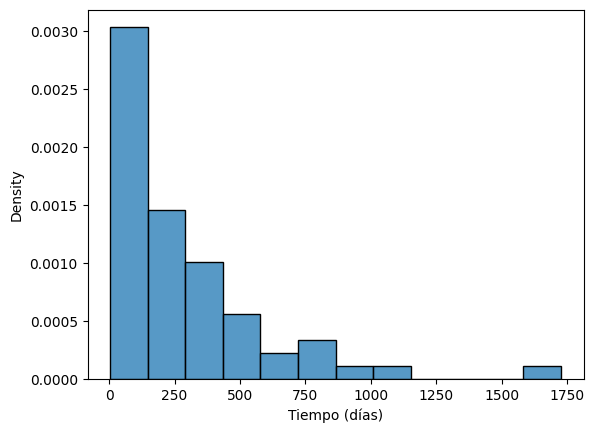

In [29]:
sns.histplot(df_sorted['time_diff'],label='Tiempo entre sismos',stat='density')
plt.xlabel('Tiempo (días)')
plt.show()

Noten también que el valor medio y el desvío estándar son muy parecidos. Esto es una propiedad de la distribución exponencial

$$y\sim exp(\beta=1/\lambda)$$

$$\bar{y}=\beta$$

$$\sigma_{y} = \beta$$

Por lo que podría ser un buen modelo de generación de datos para este problema. Como comentario, si el conteo de eventos sigue una Poisson de parámetro $\lambda$, se puede demostrar que el intervalo de tiempo entre eventos sigue una Exponencial de parámetro $\beta=1/\lambda$.

In [30]:
mu = df_sorted['time_diff'].mean()
s = df_sorted['time_diff'].std()

print('media',mu)
print('desvío',s)

media 281.659943666928
desvío 304.2713906496681


### Construcción del modelo exponencial

A continuación, pueden ver la carga del modelo exponencial, aclarando el link y la distribución a priori:

Modelo:

$$y \sim Exp(\beta)$$

Fórmula para el valor medio:

$$\beta = Intercept$$

Distribución a priori del parámetro

$$p(Intercept)\sim HN(\sigma)$$

Donde $HN$ es la distribución HalfNormal (la mitad de la campana de una distribución normal centrada en 0, lo que hace que el parámetro solo tome valores positivos). $\sigma$ se adoptó como 300, asumiendo que el parámetro no puede valer más de 600 (no más de 600 días como intervalo promedio entre sismos).

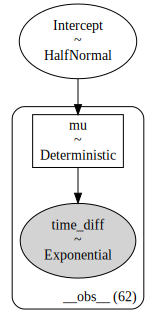

In [31]:
# Construccion del Modelo Exponencial
# Prioris
prioris = {"Intercept": bmb.Prior("HalfNormal",sigma=300)}

# Modelo
model_A = bmb.Model('time_diff~1',data=df_sorted,dropna=True,family='exponential',
                    link='identity', priors=prioris)

model_A.build()
model_A.graph()

Abajo pueden ver la distribución a priori elegido (para que se familiaricen con la forma, es muy útil para datos positivos), y la priori-predictiva para verificar que hace lo que yo quería.

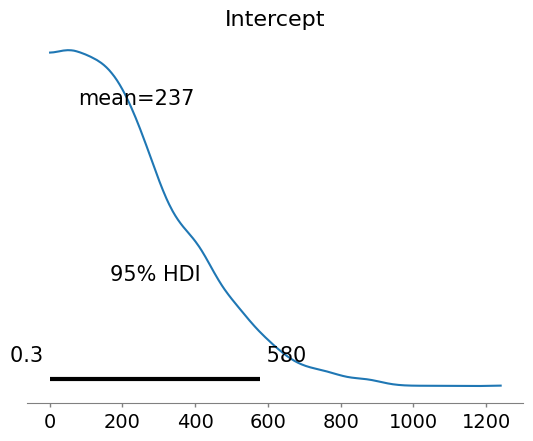

In [32]:
model_A.plot_priors(hdi_prob=0.95)
plt.show()

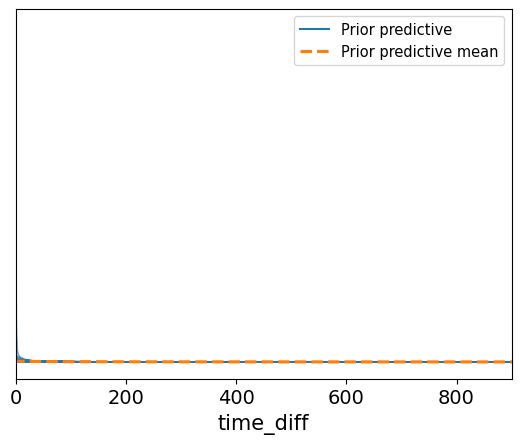

In [33]:
# Simulaciones de la priori predictive
priorcheck_A = model_A.prior_predictive()

# Gráfico
az.plot_ppc(priorcheck_A,group='prior')
plt.xlim(-1,900)
plt.show()

Luego, podemos hacer la inferencia como vimos antes, y hacer el diagnóstico...

**NOTA**: Es posible guardar los resultados de la log-verosimilitud en forma ad-hoc agregando la opción `idata_kwargs={'loglikelihood'=True}` en `.fit`

Output()

Output()

Output()

Output()

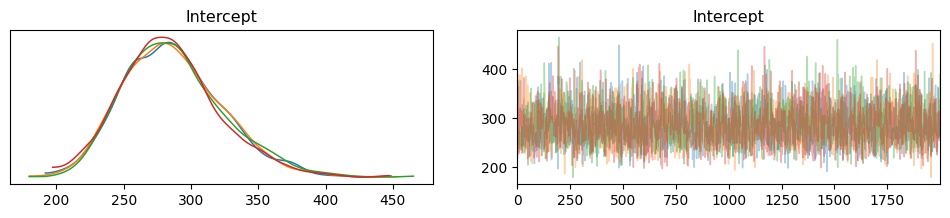

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,286.344,37.123,217.874,361.519,0.633,0.448,3438.0,4965.0,1.0


In [34]:
# Hacer inferencia
results_A = model_A.fit(draws=2000,chains=4,idata_kwargs={"log_likelihood": True})

# Diagnóstico de las cadenas

# Grafico
az.plot_trace(results_A, compact=False)
plt.show()

# Numerico
az.summary(results_A,hdi_prob=0.95)

Graficar las distribuciones posteriores de los parámetros...

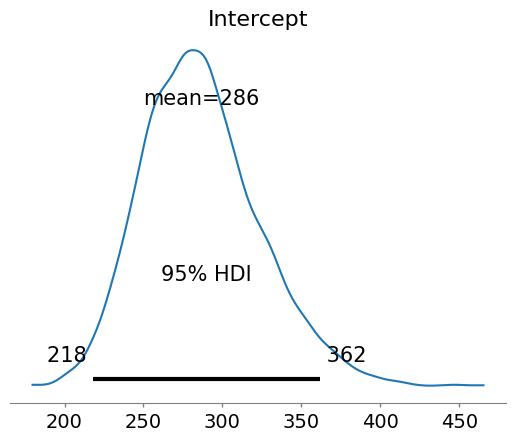

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,286.344,37.123,217.874,361.519,0.633,0.448,3438.0,4965.0,1.0


In [35]:
# Graficar las distribuciones posteriores
az.plot_posterior(results_A,var_names=['Intercept'],hdi_prob=0.95)
plt.show()

# Resumen de resultados
az.summary(results_A,var_names=['Intercept'],hdi_prob=0.95)

Y ¡generar nuevos datos y evaluar cuánto se parecen las simulaciones a los datos observados!

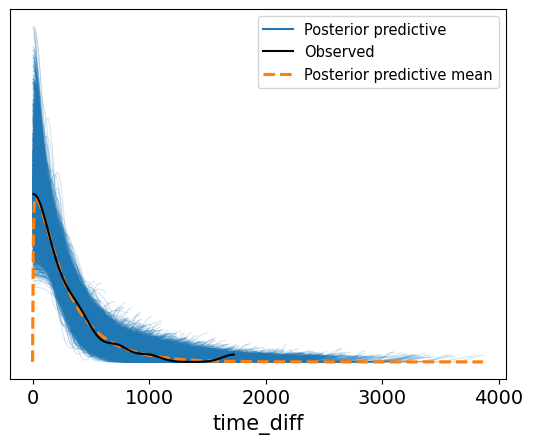

In [36]:
# Nuevas simulaciones (lo guarda en la misma variable de antes con inplace=True)
model_A.predict(results_A, kind="response",inplace=True)

# Grafico
az.plot_ppc(results_A)
plt.show()

### Construcción del modelo LogNormal

Otro modelo que se suele usar para este tipo de problemas es el LogNormal (la distirbución Gamma y Weibull también son muy usadas).

Como la LogNormal es una familia muy utilizada y que tiene sus particularidades, es importante prestarle un poco de detalle.

Por un lado, la distribución LogNormal no está pre-cargada en `Bambi`. Si bien podríamos construirla nosotros de forma relativamente sencilla, en realidad lo más común es convertir el problema a uno Normal, ajustando el logaritmo de los datos.

Es decir, en vez de resolver

$$Y\sim LN(m,s)$$

vamos a usar el modelo

$$ln(Y) \sim N(m,s)$$

¡que es un típico modelo normal muy fácil de resolver! Para hacer esto no es necesario editar el dataframe con los datos, sino que simplemente puede hacerse a través de la fórmula, aclarando que se quiere ajustar el logaritmo de la columna en vez de la columna propiamente dicha

Entonces,

Modelo:

$$ln(y) \sim N(m,s)$$

Fórmula para el valor medio (del logaritmo):

$$m = Intercept$$

Distribución a priori del parámetro

$$p(Intercept)\sim N(\sigma)$$

Nota: La distribución LogNormal tiene dos parámetros, pero solo definimos la fórmula para el valor medio. Eso es porque el desvío es considerado un término de error en `bambi` (así es en todas las distribuciones multi-paramétricas). Más adelante veremos qué pasa si queremos editar esto. Por default, entonces, `Bambi` siempre considera:

$$s = sigma$$

$$p(sigma) \sim Half-t_{\nu}(\tau)$$

o la priori que eligamos/corresponda. En este ejemplo vamos a usar las prioris por default por simplicidad, ya que estamos usando el link por default y confiamos que adoptará algo poco-informativo.

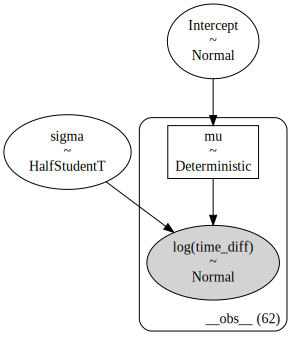

In [37]:
# Construccion del Modelo Exponencial

# Modelo
model_B = bmb.Model('log(time_diff)~1',data=df_sorted,dropna=True)

model_B.build()
model_B.graph()

Abajo pueden ver las ditribuciones a priori para `Intercept` y `sigma`.

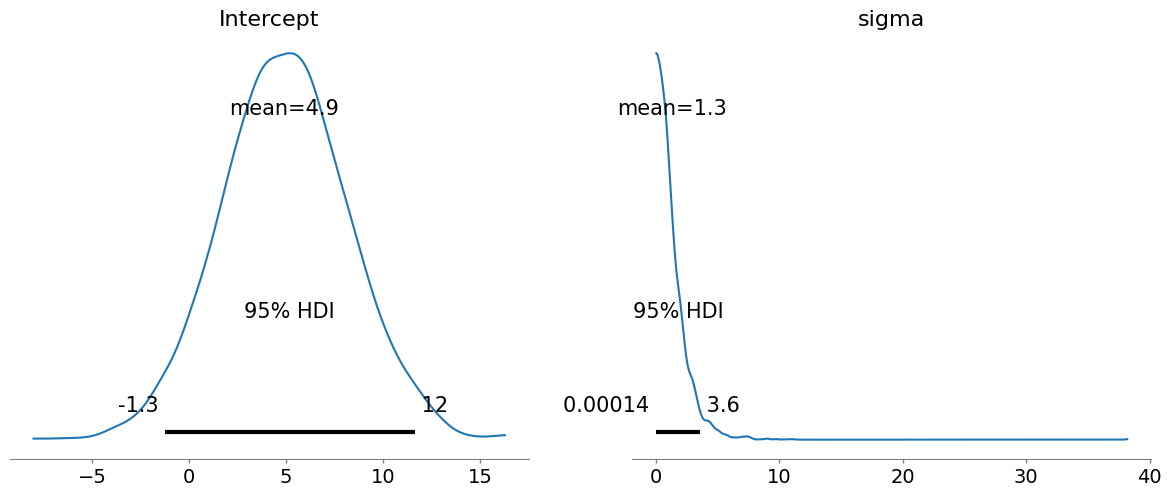

In [38]:
model_B.plot_priors(hdi_prob=0.95)
plt.show()

Y la priori predictiva. Van a notar algo "raro". ¡El modelo lo que devuelve es simulaciones del logaritmo de lo que yo quiero debido a la transformación!

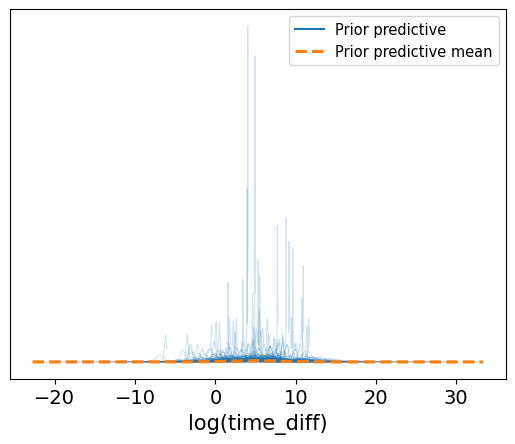

In [39]:
# Simulaciones de la priori predictive
priorcheck_B = model_B.prior_predictive()

# Gráfico
az.plot_ppc(priorcheck_B,group='prior')
#plt.xlim(-1,900)
plt.show()

In [40]:
priorcheck_B

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

Es necesario entonces, transformar los datos (y cambiarles el nombre para dejarlo de manifiesto). Esto puede hacerse con los métodos `map` y `rename` de ArviZ.

Abajo les dejamos como hacerlo. Lo recomendable es generar un nuevo Inference Data (con `inplace=False` y guardándolo en una nueva variable). Noten que esto sirve para cualquier tipo de transformación.

In [41]:
# Transformar resultados de Y a escala deseada
priorcheck_B_T = priorcheck_B.map(lambda x: np.exp(x), groups="observed_vars",
                                  inplace=False)

# Renombrar variable de log(time_diff) a time_diff luego de aplicar transformacion
priorcheck_B_T.rename(name_dict={'log(time_diff)':'time_diff'}, inplace=True)

priorcheck_B_T

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

Y ahora sí el chequeo de la priori predictiva está en mi escala original y es comparable con el modelo exponencial.

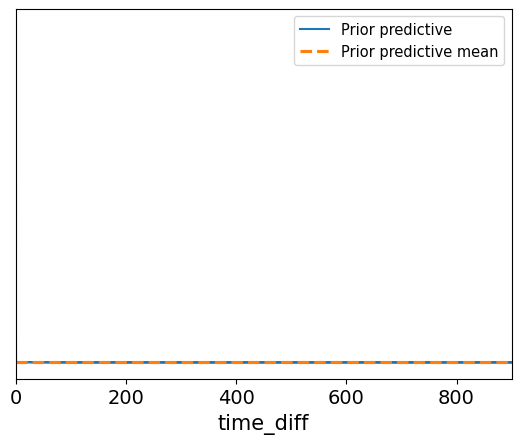

In [42]:
# Gráfico
az.plot_ppc(priorcheck_B_T,group='prior')
plt.xlim(-1,900)
plt.show()

¡Una vez que contruí el modelo es todo lo mismo de antes!

La inferencia y diagnóstico...

**NOTA**: Es posible guardar los resultados de la log-verosimilitud en forma ad-hoc agregando la opción `idata_kwargs={'loglikelihood'=True}` en `.fit`

Output()

Output()

Output()

Output()

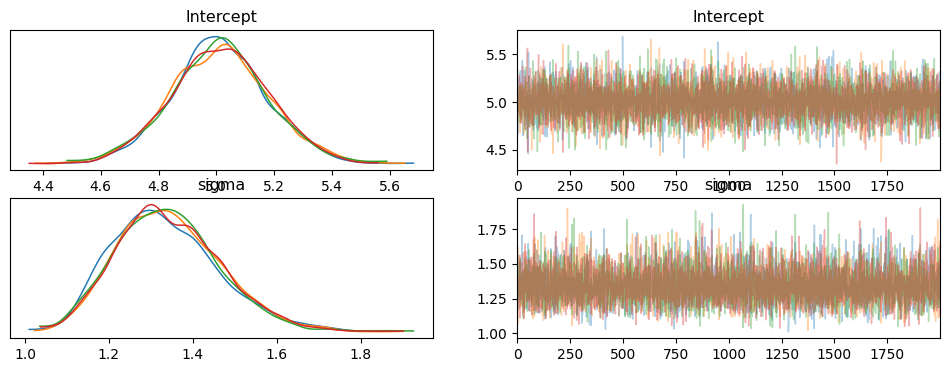

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,5.011,0.170,4.677,5.351,0.002,0.001,8171.0,5805.0,1.0
sigma,1.342,0.125,1.111,1.582,0.001,0.001,7234.0,5270.0,1.0


In [43]:
# Hacer inferencia
results_B = model_B.fit(draws=2000,chains=4,idata_kwargs={"log_likelihood": True})

# Diagnóstico de las cadenas

# Grafico
az.plot_trace(results_B, compact=False)
plt.show()

# Numerico
az.summary(results_B,hdi_prob=0.95)

Las distribuciones posteriores de los parámetros...

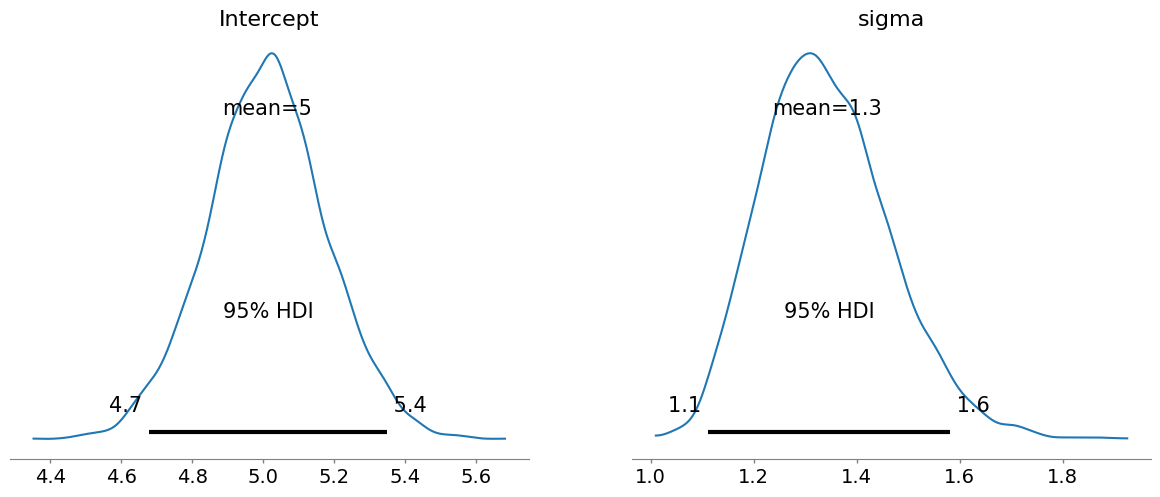

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,5.011,0.170,4.677,5.351,0.002,0.001,8171.0,5805.0,1.0
sigma,1.342,0.125,1.111,1.582,0.001,0.001,7234.0,5270.0,1.0


In [44]:
# Graficar las distribuciones posteriores
az.plot_posterior(results_B,var_names=['Intercept','sigma'],hdi_prob=0.95)
plt.show()

# Resumen de resultados
az.summary(results_B,var_names=['Intercept','sigma'],hdi_prob=0.95)

Y la simulación de nuevos datos. En este último caso, ¡haciendo la misma transformación de antes para volver a la escala original!

**NOTA**: ¡También es importante ajustar los valores de log-verosimilitud considerando el cambio de variables! Se los dejamos hecho para el caso logNormal así les queda.

Para hacerlo, lo que deben considerar es el cambio en la función de densidad (o función de verosimilitud) debido al cambio de variables. En nuestro caso tenemos que:

$$z \sim ln(y)$$

Entonces,

$$p(y) = p(z)|\frac{dz}{dy}|= \frac{1}{|y|}p(z)$$

Tomando el logaritmo, resulta:

$$ln(p(y)) = ln(p(z)|\frac{dz}{dy}|) = ln(p(z)) - ln(y)$$

Es decir que, transformar los resultados de la log-verosimilitud a la escala original ($y$) se logra restando a cada valor el dato $ln(y)$.

En otro caso pueden ver cómo plantearlo en libro de Gelman, es cuestión de obtener el Jacobiano de la función de transformación y luego aplicar el logaritmo.

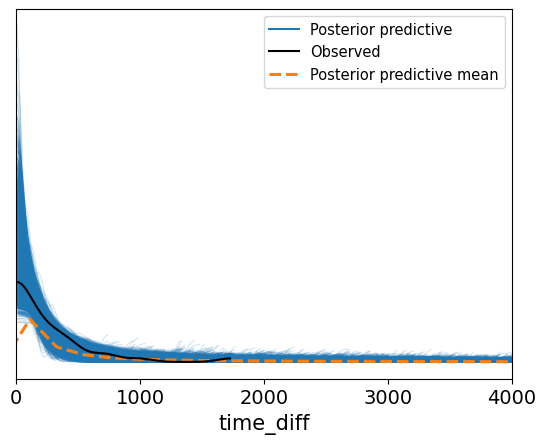

In [45]:
# Nuevas simulaciones (lo guarda en la misma variable de antes con inplace=True)
model_B.predict(results_B, kind="response",inplace=True)

# Transformar resultados de Y a escala deseada
results_B_T = results_B.map(lambda x: np.exp(x), groups="observed_vars",
                                  inplace=False)

# Renombrar variable de log(time_diff) a time_diff luego de aplicar transformacion
results_B_T.rename(name_dict={'log(time_diff)':'time_diff'}, inplace=True)

# Transformar resultados de Log-Verosimilitud a nueva escala
results_B_T = results_B_T.map(lambda x: x - np.log(results_B_T.observed_data['time_diff']),
                              groups="log_likelihood", inplace=False)

# Grafico
az.plot_ppc(results_B_T)
plt.xlim(-1,4000)
plt.show()

No parece ajustar tan bien como la exponencial, ¿no?

### QQ-plots

Así como uno puede ver con el chequeo de la predictiva visualmente cuánto se parece la posterior predictiva (y mis réplicas del ensayo) a los datos disponibles, existen otras herramientas adicionales para ver si mi modelo se ajusta a los datos.

Una de ellas es el QQ-plot. Este gráfico permite comparar los cuantiles de mis datos contra los cuantiles de mi simulación. Si las distribuciones fueran idénticas, vería una recta a 45 grados. Diferencias entre las distribuciones aparecen como desvíos respecto a esa recta.

Abajo les dejamos las funciones para graficar QQ-plots creada por nosotros, que queda disponible para los Trabajos Prácticos y el Trabajo Final.

In [46]:
def qqplot(x,y):
# FUNCION PARA GRAFICAR QQ-PLOTS
# x es el vector con los datos obtenidos mediante simulacion
# y es el vector con los datos muestras
# La funcion asume que el vector x tiene más elementos que el vector y

  from scipy.interpolate import interp1d
  from statsmodels.distributions.empirical_distribution import ECDF
  # Funciones acumuladas empíricas
  CDFx = ECDF(x)
  CDFy = ECDF(y)

  # Factores de Correccion
  Nx = len(CDFx.x)-1
  CDFx.y = CDFx.y*Nx/(Nx+1)
  Ny = len(CDFy.x)-1
  CDFy.y = CDFy.y*Ny/(Ny+1)

  # Interpolación lineal para CDFx
  CDFx_interp = interp1d(CDFx.y[1:],CDFx.x[1:])

  # Cuantiles de Y
  Qy = CDFy.x[1:]
  # Encontrar los cuantiles de de x asociados a los de y
  Qx = np.zeros(len(Qy))
  for i in range(len(Qy)):
    Qx[i] = CDFx_interp(CDFy.y[i+1])

  return Qx, Qy

In [47]:
def plot_qqplot(X,y,n_sims,ax=None):
  # Graficar QQ-plot

  # Plot
  if ax == None:
    fig, ax = plt.subplots(figsize=(5,5))

  # Post predictives
  for i in range(n_sims):
    Qx, Qy = qqplot(np.ravel(X),np.reshape(np.ravel(X),
     (-1,len(y))).T[:,np.random.randint(0,len(np.reshape(np.ravel(X),(-1,len(y)))))])
    xmin = np.min([np.min(Qx),np.min(Qy)])
    xmax = np.max([np.max(Qx),np.max(Qy)])
    ax.plot( Qx, Qy, alpha=0.2, color='C0', linewidth=1.5)

  # Observed
  Qx, Qy = qqplot(np.ravel(X),y)
  xmin = np.min([np.min(Qx),np.min(Qy)])
  xmax = np.max([np.max(Qx),np.max(Qy)])
  ax.plot( Qx, Qy, color='k', linewidth=2)

  ax.plot([xmin,xmax],[xmin,xmax], color='C1', linestyle='--')
  ax.set_xlim(xmin,xmax)
  ax.set_ylim(xmin,xmax)
  ax.grid()
  ax.set_xlabel('Cuantiles Simulación')
  ax.set_ylabel('Cuantiles Muestras')
  #plt.show()

A continuación, pueden ver los QQ-plots para cada modelo propuesto, donde las lineas azules son comparación entre los datos y las réplicas, y la negra la comparación entre los datos y la posterior predictiva (el promedio de todo).

Con este gráfico se puede ver en qué aspecto podría estar fallando mi modelo. Por ejemplo:

- Si la recta está corrida de la recta a 45 grados (traslación): Diferencia en el valor medio
- Si la recta tiene una pendiente distinta (inclinación): Diferencia en el desvío estandar
- Si la línea negra adquiere forma curva/parabólico: Diferencia en la asimetría de las distribuciones
- Si la línea negra ajusta bien el centro pero se desvío en cuantiles muy chicos o muy grandes (forma de S, por ejemplo): Diferencia en las colas de la distribución/kurtosis.

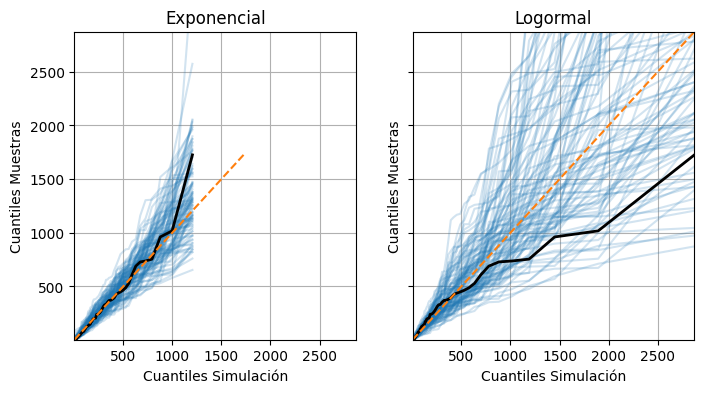

In [48]:
fig, ax = plt.subplots(1,2,figsize=(8,4),sharex=True,sharey=True)

# Exponencial
plot_qqplot(results_A.posterior_predictive['time_diff'],df_sorted['time_diff'].dropna(),100,ax=ax[0])
ax[0].set_title('Exponencial')

# Lognormal
plot_qqplot(results_B_T.posterior_predictive['time_diff'],df_sorted['time_diff'].dropna(),100,ax=ax[1])
ax[1].set_title('Logormal')

plt.show()

Como pueden ver más claramente en este gráfico respecto al de la posterior predictiva, la exponencial parece asemejarse más a los datos a la lognormal, que tiene problemas con la asimetría (va de un lado a otro en forma curva), y en general para capturar el valor medio y desvío (desfasaje y pendiente media).

### BPV-Plots

Lo que arriba detectamos cualitativamente es posible analizar cuantitavivamente a través de los p-valores bayesianos (BPV: Bayesian p-values). ¡La función `plot_bpv` lo hace por nosotros!

La clave es introducir el Inference Data, y luego indicar `kind='t_stat'`. `t_stat` puede ser cualquier estadística que querramos testear. Muchas de ellas ya están definidas en la función (valor medio `mean`, desvío `std`). A veces, queremos mirar algo en particular, por ejemplo, el máximo o mínimo valor del ensayo, la asimetría/kurtosis, el valor de un percentil en particular.

Esto se puede hacer manualmente  construyendo la función implícita, que en Python se logra con `lambda x:` siendo x la variable (en genérico el nombre) sobre la cual se trabaja

Abajo pueden ver un ejemplo para el valor medio. El gráfico es una curva de distribución de probabildad para el valor medio obtenido con las réplicas del ensayo que simulé. El punto azul es el valor medio de mis datos medidos.

Lo que queremos es que el BPV (la probabilidad de que la estadística de mi réplica con el modelo sea menor a la de los datos) sea 0.5 en ideal, o que realmente sea algo probable (caiga cerca de la moda de la distribución). No significa que mientras más cercano a 0.5 mejor, sino que lo que queremos es detectar falencias. Es decir, valores muy chicos (<0.1) o muy grandes (>0.9) que indican que es muy, muy improbable que mi modelo replique esa estadística de mis datos.

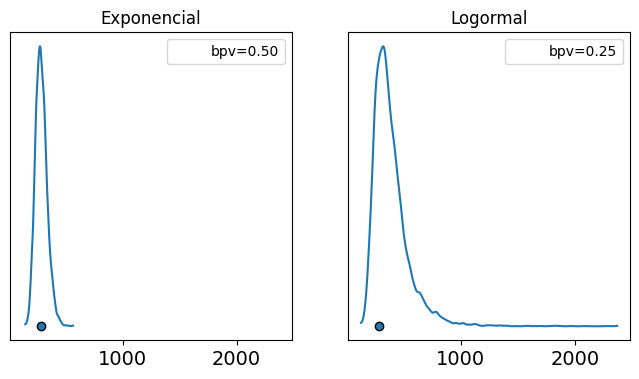

In [49]:
fig, ax = plt.subplots(1,2,figsize=(8,4),sharex=True)

# Normal
az.plot_bpv(results_A,kind='t_stat',t_stat='mean',
            ax=ax[0])
ax[0].set_title('Exponencial')

# Lognormal
az.plot_bpv(results_B_T,kind='t_stat',t_stat='mean',
            ax=ax[1])
ax[1].set_title('Logormal')

plt.show()

Arriba se ve, por ejemplo, que la exponencial ajusta bien el valor medio de los datos (es lógico, es el parámetro que calibrarmos). No tan así la lognormal.

Abajo pueden ver la construcción manual de la BPV para el desvío estandar, para que se familiaricen con la construcción de estadísticas ad-hoc a chequar.

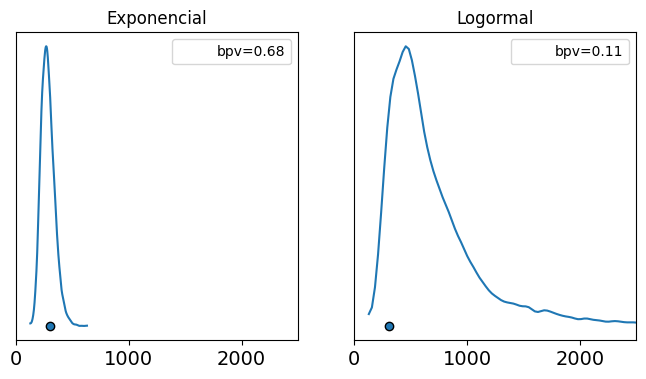

In [50]:
fig, ax = plt.subplots(1,2,figsize=(8,4),sharex=True)

# Normal
az.plot_bpv(results_A,kind='t_stat',t_stat=lambda x: np.std(x,ddof=1,axis=-1),
            ax=ax[0])
ax[0].set_title('Exponencial')

# Lognormal
az.plot_bpv(results_B_T,kind='t_stat',t_stat=lambda x: np.std(x,ddof=1,axis=-1),
            ax=ax[1])
ax[1].set_title('Logormal')
ax[1].set_xlim(0,2500)

plt.show()

Noten que mientras que a la lognormal le cuesta mucho simular el desvío en mis datos! Esta es una señal de que el modelo está fallando en ese sentido, algo que pudimos ver antes en el QQ-Plot.

### Capacidad predictiva

La última evaluación que vamos a ver es la de ponerle números a la idea original de "cuál era la probabilidad de ver mis datos según este modelo". Esto lo podemos contestar a partir de la capacidad predictiva del modelo o LPPD (log posterior predictive density).

Si bien a lo largo del curso veremos mejores herramientas de estimar la capacidad predictiva, lo más rápido y directo es simplemente calcular la probabilidad (o densidad de probabilidad) de ver los datos:

$$lppd = \sum_{i} ln(\int p(y=y_{i}|\mathbf{\theta})P(\theta|\mathbf{y})d\theta)$$

A mayor valor de $lppd$, mayor era la probabilidad de ver los datos, así que puede ser una buena forma de ver cuál modelo "se ajusta mejor a los datos".

Más adelante veremos formas de hacer mejores estimaciones y considerar incertidumbres en este análisis.

¡Fijensé que la cuenta es implemente una sumatoria de las log-verosimilitudes (promediando en los parámetros primero)!

In [56]:
# Caso Exponencial
lppd_A = np.sum(np.mean(results_A.log_likelihood['time_diff'].values,(0,1)))

# Caso Lognormal
lppd_B = np.sum(np.mean(results_B_T.log_likelihood['time_diff'].values,(0,1)))

print('lppd (Exponencial):',lppd_A)
print('lppd (Lognormal):',lppd_B)

lppd (Exponencial): -412.2292099555501
lppd (Lognormal): -416.30702198335655


En este caso no pareciera haber "mucha" diferencia (vamos a ver a futuro como se mide), pero el modelo exponencial tiene un valor mayor (es menos negativo)

### Uso del Modelo

Supongamos que con lo que vimos arriba decidimos que el mejor modelo para estos datos es el exponencial. ¡Ahora ya podemos usarlo para contestar preguntas!

La primer pregunta era: ¿Cuál es la probabilidad de que el intervalo entre sismos supere los 2 años?

Extrayendo las simulaciones del Inference Data, esto lo podemos contestar por conteo igual que antes.

In [57]:
# Accedo a los datos
Simul = results_A.posterior_predictive['time_diff'].values

# Probabilidad de superar un intervalo de 2 años
P0 = np.mean(np.ravel(Simul)>2*365)
print('Probabilidad de que el intervalo entre sismos supere 2 años:',round(P0,3))

Probabilidad de que el intervalo entre sismos supere 2 años: 0.079


#### ROPE y test de hipótesis

La otra pregunta era: ¿Puedo decir que el valor medio del intervalo entres sismos es distinto a 1 año?

Este tipo de preguntas puede plantearse como un test de hipótesis. La idea es:

- Definir la hipótesis $H_{0}$. En este caso, que $\beta=365$
- Definir un criterio de decisión, a partir de qué probabilidad acepto o rechazo $H_{0}$ (el nivel de significancia $\alpha$
- Calcular la probabilidad de que $H_{0}$ sea cierto según mis simulaciones
- Aceptar o rechazar $H_{0}$ si es posible.

Como la probabilidad de un valor puntual es 0 en variables continuas, lo más apropiado sería definir un rango de valores razonables que en la práctica son equivalentes, conocido como ROPE.

Por ejemplo, para mi que el intervalo entre sismos sea 11 meses, 12 meses o 13 meses es lo mismo que decir "1 año" a fines prácticos. Así que mi ROPE para el test de hipótesis es $335<\beta<395$.

Luego defino la signifancia para la toma decisiones, el cual define mi Intervalo de Confianza. Puedo tomar por ejemplo, el IC de 90%.

Con esto, la función `plot_posterior` (¡les dijimos que era muy versatil!) hace todo por nosotros. Fijensé que se le puede cargar a la función un vector o matriz de simulaciones, no necesariamente un Inference Data, así que sirve para simulaciones analíticas también.

Luego, deben aclarar las variables `hdi_prob` (el IC) y la variable `ROPE` (el rango de valores a testear como lista).

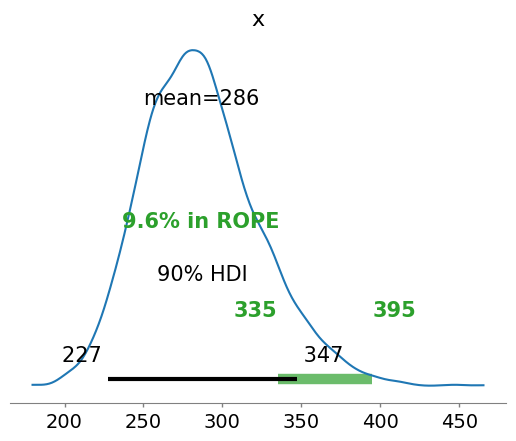

In [58]:
## Accedo a los datos
Simul = results_A.posterior['Intercept'].values

# Graficar las distribuciones posteriores
az.plot_posterior(Simul,hdi_prob=0.90,rope=[335,395])
plt.show()

Lo que devuelve es un gráfico donde se ve en verde el ROPE y en negro el IC. a su vez, muetra la probabilidad de que las simulaciones caigan dentro del ROPE para que ustedes acepten o rechacen $H_{0}$.

La regla de pulgar para el test de hipótesis es la siguiente:
- Si el IC está completamente contenido en el ROPE, entonces acepto $H_{0}$ (la probabilidad me va a dar mayor a $\alpha$)
- Si el IC está completamente fuera del ROPE, entonces rechazo $H_{0}$ (la probabilidad me va a dar menor a $1-\alpha$
- Si hay superposición no puede afirmar ni rechazar nada. (tal vez con más datos se achica mi IC y logro llegar a una conclusión. O tal vez encuentro un mejor modelo explicativo con menos incertidumbre).

En este caso particular, como hay solape no puedo afirmar ni rechazar que el valor medio del intervalo entre sismos sea disinto de 1.

Más allá de eso, lo más correcto es informar la probabilidad y que la persona interesada tome la decisión que le parezca más apropiada. Es decir, informar que "De acuerdo al modelo, hay un 90.9% de chances que el promedio de tiempo entre sismos sea distinto a 1 año +/- 1 mes".